In [ ]:
pip install -q tensorflow==2.3.1

     |████████████████████████████████| 320.4MB 55kB/s 


In [ ]:
pip install -q tensorflow-quantum

     |████████████████████████████████| 5.9MB 12.4MB/s 
     |████████████████████████████████| 5.6MB 23.2MB/s 
     |████████████████████████████████| 1.6MB 47.3MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
a, b = sympy.symbols('a b')

q0, q1 = cirq.GridQubit.rect(1, 2)
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1), cirq.CNOT(control=q0, target=q1))

cirq_simulator = cirq.Simulator()
z0 = cirq.Z(q0)

In [ ]:
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

In [ ]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.string,
                                name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

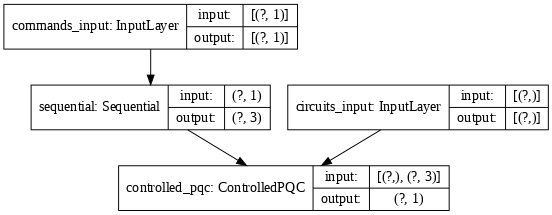

In [ ]:
# Dense layer for the controller and command input
dense_2 = controller(commands_input)

# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])

# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [ ]:
# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

# Miscalibrating the quantum circuit and making one copy for each data point (n=2)
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(cirq.rx(random_rotations[0])(qubit), cirq.ry(random_rotations[1])(qubit), cirq.rz(random_rotations[2])(qubit))
datapoint_circuits = tfq.convert_to_tensor([noisy_preparation] * 2)  # Make two copied of this circuit

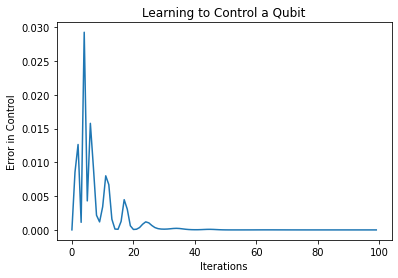

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=100,
                    verbose=0)

plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()


In [ ]:
def check_error(command_values, desired_values):
  """Based on the value in `command_value` see how well you could prepare
  the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
  params_to_prepare_output = controller(command_values).numpy()
  full_circuit = noisy_preparation + model_circuit

  # Test how well you can prepare a state to get expectation the expectation
  # value in `desired_values`
  for index in [0, 1]:
    state = cirq_simulator.simulate(
        full_circuit,
        {s:v for (s,v) in zip(control_params, params_to_prepare_output[index])}
    ).final_state
    expectation = z0.expectation_from_wavefunction(state, {qubit: 0}).real
    print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expectation}\n')


check_error(commands, expected_outputs)

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [ 0.29402682  0.16275215 -0.812215  ]
Which gives an actual expectation of: 0.9995236396789551

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [-2.6150348 -9.387202   5.4998145]
Which gives an actual expectation of: -0.9997806549072266



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: StateVectorTrialResult.final_state was used but is deprecated.
It will be removed in cirq v0.10.0.
Use final_state_vector instead.

  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: PauliString.expectation_from_wavefunction was used but is deprecated.
It will be removed in cirq v0.10.0.
Use expectation_from_state_vector instead

  


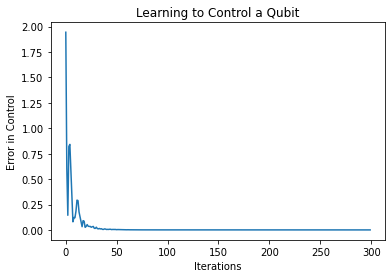

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [ 0.2626354 -0.673415   1.1981827]
Which gives an actual expectation of: 0.9922557473182678

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [ -3.5305831 -11.381677    8.761541 ]
Which gives an actual expectation of: -0.9901177883148193

For a desired output (expectation) of [0.5] with noisy preparation, the controller
network found the following values for theta: [ -7.423326 -22.355661  16.087498]
Which gives an actual expectation of: 0.4992715120315552

For a desired output (expectation) of [-0.5] with noisy preparation, the controller
network found the following values for theta: [-11.296317 -33.3443    23.280954]
Which gives an actual expectation of: -0.5000528693199158



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: StateVectorTrialResult.final_state was used but is deprecated.
It will be removed in cirq v0.10.0.
Use final_state_vector instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: PauliString.expectation_from_wavefunction was used but is deprecated.
It will be removed in cirq v0.10.0.
Use expectation_from_state_vector instead



In [ ]:

# The command input values to the classical NN.
commands = np.array([[0], [1], [2], [3]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1], [.5], [-0.5]], dtype=np.float32)

random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit))

datapoint_circuits = tfq.convert_to_tensor([noisy_preparation] * 4)  # Make four copied of this circuit

optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=300,
                    verbose=0)

plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

def check_error(command_values, desired_values):
  """Based on the value in `command_value` see how well you could prepare
  the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
  params_to_prepare_output = controller(command_values).numpy()
  full_circuit = noisy_preparation + model_circuit

  # Test how well you can prepare a state to get expectation the expectation
  # value in `desired_values`
  for index in range(4):
    state = cirq_simulator.simulate(
        full_circuit,
        {s:v for (s,v) in zip(control_params, params_to_prepare_output[index])}
    ).final_state
    expectation = z0.expectation_from_wavefunction(state, {qubit: 0}).real
    print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expectation}\n')


check_error(commands, expected_outputs)